## MutSplice analysis

Notebook that looks at the impact of RBP motifs in the predictions of SpliceAI. 

In [276]:
import seaborn as sns 
import matplotlib.gridspec
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 1000)
import numpy as np
import scipy
import itertools
import math
from plotnine import *

In [277]:
effect_cols = ['acceptor_upstream_effect', 'donor_upstream_effect', 'acceptor_cassette_effect', 
               'donor_cassette_effect', 'acceptor_downstream_effect', 'donor_downstream_effect']

#### Load the data

In [278]:
# Rosina db
PATH_KD = '2_mutsplice/Rosina2017_plain_KD_MutSplice.tsv.gz'
PATH_CTRL = '2_mutsplice/Rosina2017_plain_Ctrl_MutSplice.tsv.gz'

# Analysis refer to the impact of perturbations up to the SpliceAI resolution (5000bp on each side of the cassette exon)
DEL_KD = pd.read_csv(PATH_KD, sep="\t")
DEL_CTRL = pd.read_csv(PATH_CTRL, sep="\t")

In [279]:
DEL_KD['exon_group'] = 'KD'
DEL_CTRL['exon_group'] = 'CTRL'
DATA = pd.concat([DEL_KD, DEL_CTRL]).reset_index(drop=True)

In [280]:
# Set data types
int_cols = [c for c in DATA.columns if any(x in c for x in ['start', 'end', 'distabce'])] + ['n_at_density_block']
DATA[int_cols] = DATA[int_cols].astype('int32', errors='ignore')

float_cols = DATA.select_dtypes(include=[np.float32]).columns
DATA[float_cols] = DATA[float_cols].astype(np.float32)


to_bool = ['has_self_submotif', 'has_other_submotif', 'is_high_density_region']
DATA[to_bool] = DATA[to_bool].replace({'Yes': True, 'No': False})

discrete_cols = ['type', 'mutation', 'location']
DATA[discrete_cols] = DATA[discrete_cols].astype(pd.CategoricalDtype())
print(f"Number of motif hits: {DATA.shape[0]}")

Number of motif hits: 736868


#### Remove motifs outside the exon triplet region

In [281]:
def _keep_only_within_exon_triplet(row: pd.Series):
	'''
	Keep motif ocurrences within the boundaries of the triplet exon
	'''
	if row.id.endswith('_REF_seq'):
		return True

	elif row.location == 'Intron_upstream_2':
		if row.start >= row.start_exon_upstream - 100:
			return True
		else:
			return False
	elif row.location == 'Intron_downstream_2':
		if row.end <= row.end_exon_downstream + 100:
			return True
		else:
			return False    
	else:
		return True

In [282]:
mask = DATA.apply(_keep_only_within_exon_triplet, axis=1)
n_before = DATA.shape[0]
DATA = DATA[mask]
print(f"Number of motif removed due being located outside of the exon triple: {n_before - DATA.shape[0]}")

Number of motif removed due being located outside of the exon triple: 366728


#### Remove data from RBP Knockdowns that had few events (< 40) detected

In [283]:
less_than_40 = ['RBM14', 'CDC40', 'SUGP2', 'TIA1', 'RBM5', 'DDX5', 'PPP1R8', 'HNRNPD',
       'HNRNPA2B1', 'ADAR', 'PRPF6', 'STAU1', 'RBM47', 'PPIG', 'TRA2A',
       'PSIP1', 'FMR1', 'ZRANB2', 'SND1', 'BUD13', 'CCAR2', 'SRSF4', 'DDX20']
less_than_30 = ['DDX5', 'PPP1R8', 'HNRNPD', 'HNRNPA2B1', 'ADAR', 'PRPF6', 'STAU1',
       'RBM47', 'PPIG', 'TRA2A', 'PSIP1', 'FMR1', 'ZRANB2', 'SND1', 'BUD13',
       'CCAR2', 'SRSF4', 'DDX20']

In [284]:
n_before = DATA.shape[0]
DATA = DATA[~DATA.rbp_name.isin(less_than_40)] 
print(f"Number of motifs removed from knockdown experiments with few total number of events detected: {n_before - DATA.shape[0]}")

Number of motifs removed from knockdown experiments with few total number of events detected: 808


#### Remove data from RBP Knockdowns that had less than 40 motif occurrences across KD and CTRL exons

In [285]:
def getCountsPerRBP(data: pd.DataFrame):
	total_counts_per_rbp = data.groupby(['rbp_name']).size().reset_index().rename(columns={0: 'total_counts'})
	total_counts_per_rbp['rbp_name_with_N'] = total_counts_per_rbp.rbp_name + " (N=" + total_counts_per_rbp.total_counts.astype(str) + ")"

	counts_per_rbp = data.groupby(['rbp_name', 'exon_group']).size().reset_index().rename(columns={0: 'group_counts'}).sort_values(by='group_counts', ascending=False)
	counts_per_rbp = pd.merge(counts_per_rbp, total_counts_per_rbp, on='rbp_name')
	counts_per_rbp['percentage'] = counts_per_rbp.group_counts / counts_per_rbp.total_counts * 100
	return counts_per_rbp

def doBinomialTest(counts_per_rbp: pd.DataFrame):
	pvals = counts_per_rbp.groupby('rbp_name_with_N').apply(lambda x: scipy.stats.binomtest(x[x.exon_group == "KD"].iloc[0].group_counts, x.iloc[0].total_counts, p=0.5, alternative='two-sided').pvalue)
	pval_corrected = smm.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[0]
	is_sign_df = pd.DataFrame({'rbp_name_with_N': pvals.index, 'is_sign': pval_corrected}).replace({True: "*", False: 'ns'})
	return pd.merge(counts_per_rbp, is_sign_df, on='rbp_name_with_N')

In [286]:
counts_per_rbp = getCountsPerRBP(DATA)
rbps_with_low_count = counts_per_rbp[counts_per_rbp.total_counts < 40].rbp_name.unique()
counts_per_rbp = counts_per_rbp[~counts_per_rbp.rbp_name.isin(rbps_with_low_count)]
DATA = DATA[~DATA.rbp_name.isin(rbps_with_low_count)]
print(f"Removed data from exon pairs ({','.join(rbps_with_low_count)}) with less than 40 motif occurrences")

Removed data from exon pairs (FUS,SF1) with less than 40 motif occurrences


#### Motif counts

In [287]:
# Total motif counts, regardless of exon group
def plotMotifOccurrences(data: pd.DataFrame):
    # Stacked horizontal barplot
    _counts_per_rbp = data.groupby('rbp_name').size().sort_values(ascending=False)

    # Total counts per RBP
    sns.set(font_scale = 1)
    sns.set_color_codes("pastel")
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
    sns.barplot(x=_counts_per_rbp.values, y=_counts_per_rbp.index,
                orient='h', color="b", order=_counts_per_rbp.index, linewidth=1, edgecolor='black', ax=axes[0])
    sns.despine(left=True, bottom=True)
    plt.xlabel('# Deletions')
    plt.ylabel('RBP name')
    plt.rc('xtick', labelsize=14)   
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=15)


    counts_per_rbp2 = _counts_per_rbp[_counts_per_rbp < 10000]
    ax2 = sns.barplot(x=counts_per_rbp2.values, y=counts_per_rbp2.index,
                    orient='h', color="b", order=counts_per_rbp2.index, linewidth=1, edgecolor='black', ax=axes[1])
    ax2 = sns.despine(left=True, bottom=True)
    plt.xlabel('# Deletions')
    plt.ylabel('RBP name')
    plt.rc('xtick', labelsize=14)   
    plt.rc('ytick', labelsize=12) 
    plt.rc('axes', labelsize=15)
    f.tight_layout(pad=3.0)

In [288]:
# Fraction of motifs per RBP plot, regardess of exon group
def plotMotifFraction(data: pd.DataFrame):
	# Get fraction of motif ocurrence per RBP
	f, ax = plt.subplots(figsize=(7, 7))
	pct_per_rbp = data.groupby(['rbp_name', 'mutation']).size() / data.groupby('rbp_name').size()
	df_pct = pd.DataFrame(pct_per_rbp, columns=['pct']).reset_index()

	df_pct['Motif ID'] = df_pct.groupby('rbp_name').cumcount()+1
	df_pct['RBP'] = pd.Categorical(df_pct['rbp_name'], list(df_pct.groupby('rbp_name').size().sort_values(ascending=False).index))
	ax = sns.histplot(df_pct, y='RBP', hue='Motif ID', weights='pct', palette='tab20c', multiple='stack', shrink=0.99, kde_kws=dict(linewidth=0.2, edgecolor='black')) 
	ax.get_legend().remove()
	ax.set_xlabel('Motif fraction', fontsize=18)
	ax.set_title('Fraction of motif ocurrences per RBP knockdown', fontsize=20)
	plt.show()
	return df_pct

In [289]:
import statsmodels.stats.multitest as smm
def plotMotifOccurrencesPerGroup(counts_per_rbp: pd.DataFrame, outbasename: str = 'all_hits'):
    
    # Make plot
    fig, ax = plt.subplots(figsize=(8, 8))
    counts_per_rbp['exon_group'] = pd.Categorical(counts_per_rbp['exon_group'], ['CTRL','KD'])
    plt.rcParams['patch.linewidth'] = 2
    plt.rcParams['patch.edgecolor'] = 'k'
    plt.rcParams["patch.force_edgecolor"] = True
    ax = sns.histplot(counts_per_rbp, y='rbp_name_with_N', hue='exon_group', weights='percentage', palette=['#FFE4E1', '#8B8378'], multiple='stack', kde_kws=dict(edgecolor="k", linewidth=2)) 

    ax.axvline(50, color='k', ls='--')

    i=0
    for name, group in counts_per_rbp.groupby('rbp_name_with_N', sort=False):

        is_sign = group.iloc[0].is_sign
        ax.text(45, i + 0.25, is_sign, fontdict=dict(fontsize=13))
        i += 1
        
    plt.rc('xtick', labelsize=16)   
    plt.rc('ytick', labelsize=13)
    plt.xlabel('Percentage of motifs found', size=16)
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'plots/3_mutsplice_motif_counts_{outbasename}.pdf')

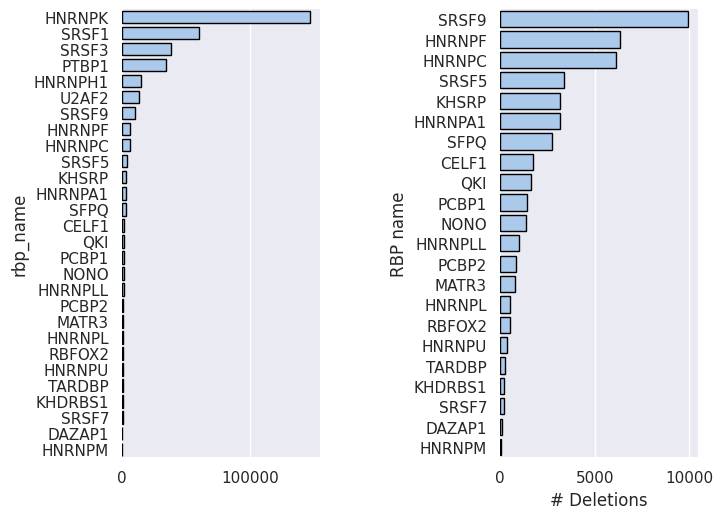

In [290]:
plotMotifOccurrences(DATA)

/tmp/ipykernel_2740566/373192956.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


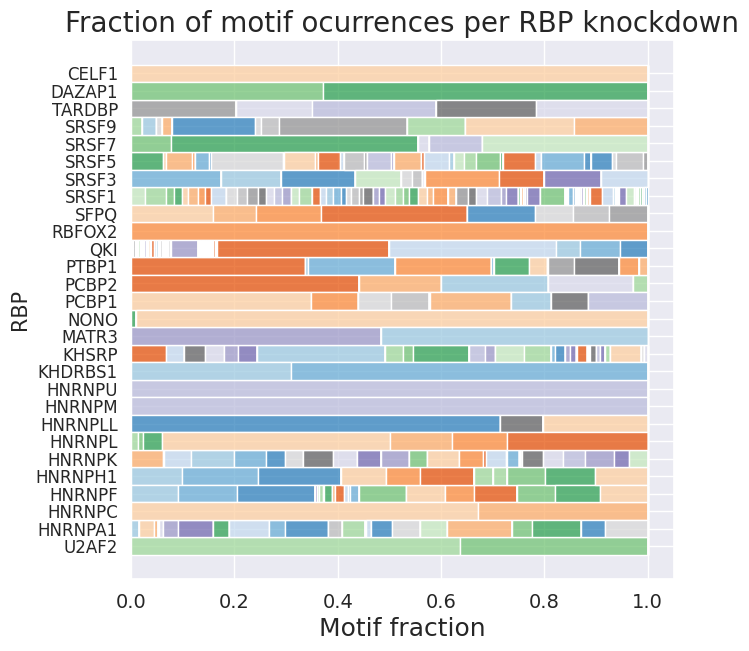

In [291]:
df_pct = plotMotifFraction(DATA)

/tmp/ipykernel_2740566/4075927803.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


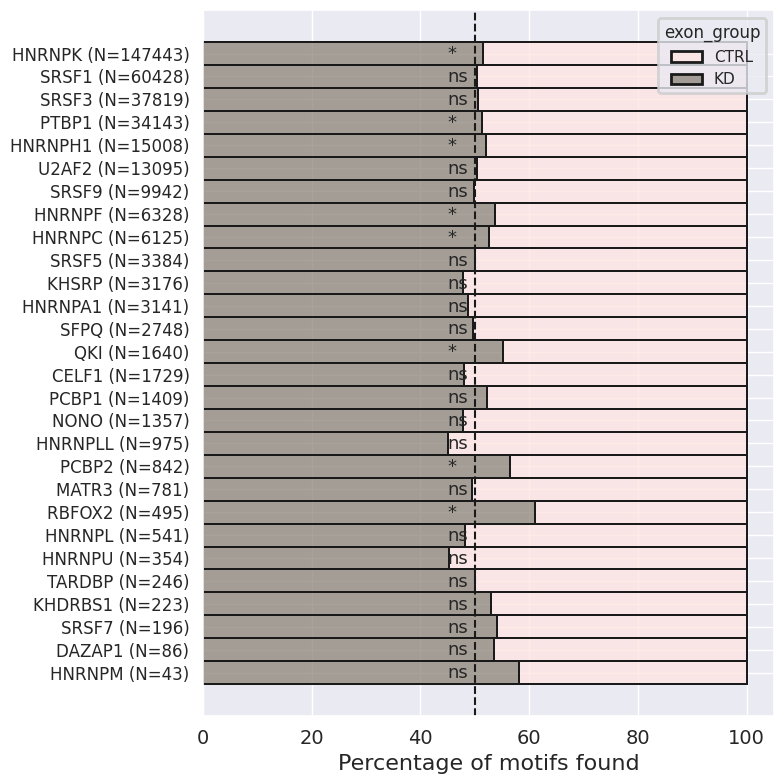

In [292]:
plotMotifOccurrencesPerGroup(doBinomialTest(counts_per_rbp))

#### Check effects on each exon of the triplet

In [293]:
any_effect = DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05 or \
                              abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05 or \
                              abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05 or \
                              other_acceptor_effect == other_acceptor_effect or \
                              other_donor_effect == other_donor_effect')

upstream_effect = DATA.query('abs(acceptor_upstream_effect) >= 0.05 or abs(donor_upstream_effect) >= 0.05')
ups_effect_pos = DATA.query('acceptor_upstream_effect >= 0.05 or donor_upstream_effect >= 0.05')
ups_effect_neg = DATA.query('acceptor_upstream_effect <= -0.05 or donor_upstream_effect <= -0.05')

cassette_effect = DATA.query('abs(acceptor_cassette_effect) >= 0.05 or abs(donor_cassette_effect) >= 0.05')
cass_effect_pos = DATA.query('acceptor_cassette_effect >= 0.05 or donor_cassette_effect >= 0.05')
cass_effect_neg = DATA.query('acceptor_cassette_effect <= -0.05 or donor_cassette_effect <= -0.05')

downstream_effect = DATA.query('abs(acceptor_downstream_effect) >= 0.05 or abs(donor_downstream_effect) >= 0.05')
down_effect_pos = DATA.query('acceptor_downstream_effect >= 0.05 or donor_downstream_effect >= 0.05')
down_effect_neg = DATA.query('acceptor_downstream_effect <= -0.05 or donor_downstream_effect <= -0.05')

other_effect = DATA[(~DATA.other_acceptor_effect.isna()) |
                         (~DATA.other_donor_effect.isna()) ]

In [294]:
# Any effect
any_pct = any_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
upstream_pct = upstream_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_pct = cassette_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_pct = downstream_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
other_pct = other_effect.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100

list_dfs = [any_pct, upstream_pct, cassette_pct, downstream_pct, other_pct]
pct_df = pd.concat(list_dfs, axis=1)
pct_df.columns = ['Any diff', 'Upstream diff', 'Cassette diff', 'Downstream diff', 'Other diff']
pct_df = pct_df.fillna(0)

# Pos and Neg effects
upstream_pos_pct = ups_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
upstream_neg_pct = ups_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_pos_pct = cass_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
cassette_neg_pct = cass_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_pos_pct = down_effect_pos.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100
downstream_neg_pct = down_effect_neg.groupby('rbp_name').size() / DATA.groupby('rbp_name').size() * 100

list_dfs_pos_neg = [upstream_pos_pct, upstream_neg_pct, cassette_pos_pct, cassette_neg_pct, downstream_pos_pct, downstream_neg_pct]
pct_df_pos_neg = pd.concat(list_dfs_pos_neg, axis=1)
pct_df_pos_neg.columns = ['+ Upstream diff', '- Upstream diff', '+ Cassette diff', '- Cassette diff', '+ Downstream diff', '- Donwstream diff']
pct_df_pos_neg = pct_df_pos_neg.fillna(0)

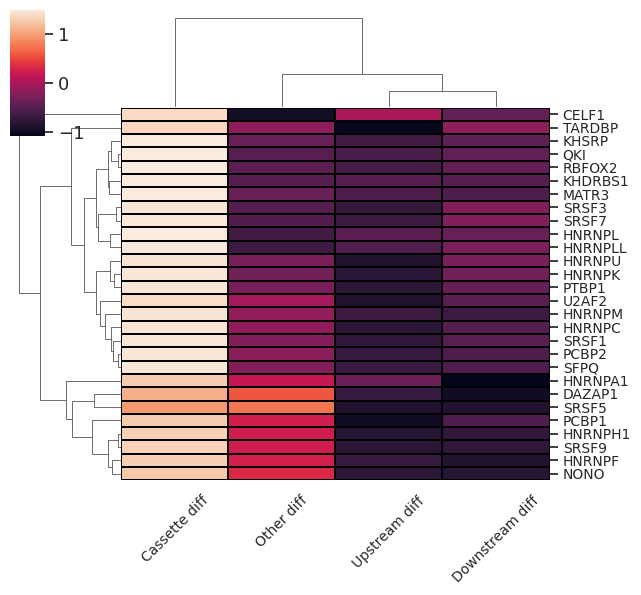

In [295]:
# Overall effects
h = sns.clustermap(pct_df.loc[~(pct_df==0).all(axis=1)].drop('Any diff', axis=1), 
              z_score=0,linecolor='black',linewidths=0.01, figsize=(7,7), annot=False, yticklabels=True)
h.ax_heatmap.set_ylabel("")
xticklabels = h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), rotation=45, fontsize = 10)
yticklabels = h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_ymajorticklabels(), fontsize = 10)

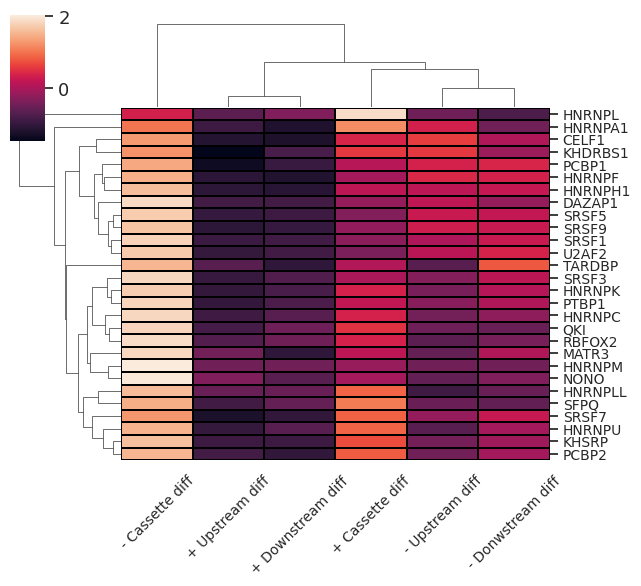

In [296]:
# Specific effects
h = sns.clustermap(pct_df_pos_neg.loc[~(pct_df_pos_neg==0).all(axis=1)], 
              z_score=0,linecolor='black',linewidths=0.01, figsize=(7,7), annot=False, yticklabels=True)
h.ax_heatmap.set_ylabel("")
xticklabels = h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xmajorticklabels(), rotation=45, fontsize = 10)
yticklabels = h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_ymajorticklabels(), fontsize = 10)

#### Cassette exon analysis

/tmp/ipykernel_2740566/4075927803.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


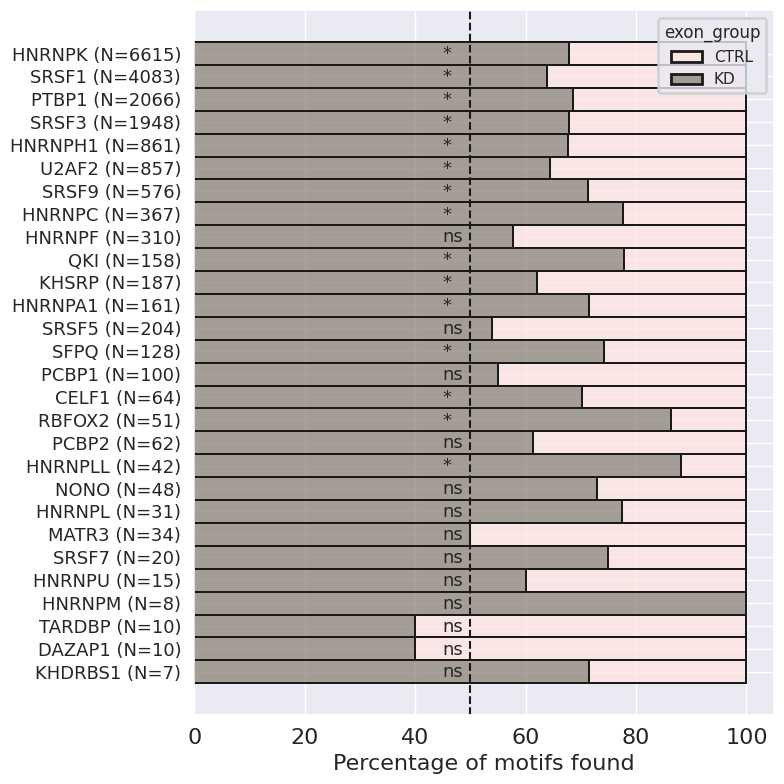

In [297]:
plotMotifOccurrencesPerGroup(doBinomialTest(getCountsPerRBP(cassette_effect)), outbasename='cassette_effect')

#### Getting the data

In [298]:
def max_abs_effect(row):
    if abs(row[donor_col]) > abs(row[acceptor_col]):
        return row[donor_col]
    else:
        return row[acceptor_col]
    
donor_col = 'donor_cassette_effect'
acceptor_col = 'acceptor_cassette_effect'

In [299]:
# Order RBP databy the number of motif occurrences
_counts = DATA['rbp_name'].value_counts()
DATA['rbp_name'] = DATA['rbp_name'].astype(pd.CategoricalDtype(categories=_counts.index, ordered=True))

# Add a column with the maximum absolute effect
DATA['mutation_effect'] = DATA.apply(max_abs_effect, axis=1)
DATA['cass_diff'] = DATA[[donor_col, acceptor_col]].abs().ge(0.05).any(axis=1)
DATA.is_in_exon = DATA.is_in_exon.replace({True: "Exon", False: "Intron"})
DATA = DATA.rename(columns={"is_in_exon": "Location of motif"})
    
cass = DATA[DATA.exon_group == "KD"].copy()
cass_ctrl = DATA[DATA.exon_group == "CTRL"].copy()

#### Scatterplot to correlation between donor and acceptor

In [318]:
def plotDonorAndAcceptorCorrelation(data: pd.DataFrame, per_rbp: bool = False):
        # Do linear regression to extract the statistics to annotate the plots
        if per_rbp:
                N_df = data.groupby('rbp_name').size().reset_index().rename({0: 'N'}, axis=1)
                N_df['N'] = N_df.N.apply(lambda x: "N={}".format(str(x)))
                p1 = (ggplot(data[data.cass_diff], aes(x=donor_col, y=acceptor_col))
                        + geom_point(aes(color='Location of motif'), size=0.5, alpha = 0.5)
                        + geom_smooth(se=True, method="lm", color="black") 
                        + facet_wrap('rbp_name', ncol=8)
                        + geom_text(data = N_df, mapping=aes(label = 'N', x = 0, y = 0.9), size=8)
                        + labs(x='Donor', y='Acceptor') 
                        + ylim(-1, 1)
                        + xlim(-1, 1)
                        + theme(figure_size=(11, 10), axis_text_y=element_text(size=7), axis_text_x=element_text(size=7, angle=45))
                        + coord_fixed(ratio=1)
                )
                
        else:      
                slope_a, intercept_a, rvalue_a, _, _ = scipy.stats.linregress(data[donor_col], data[acceptor_col])

                p1 = (ggplot(data, aes(x=donor_col, y=acceptor_col)) +
                        geom_point(aes(color='Location of motif'), alpha = 0.5) + 
                        geom_smooth(se=True, method="lm", color="black") + 
                        annotate("text", x = 0, y = 0.9, label = "N={}".format(data.shape[0])) +
                        xlab('Donor') +
                        ylim(-1, 1) +
                        xlim(-1, 1) +
                        theme(figure_size=(5, 5)) +
                        coord_fixed(ratio=1) +
                        ylab('Acceptor') +
                        annotate('text', x=0, y = 0.8, size=8, label='y = {}x + {}, r2 = {}'.format(str(round(slope_a, 3)), str(round(intercept_a, 3)), str(round(rvalue_a ** 2, 3))))
                )
        return p1

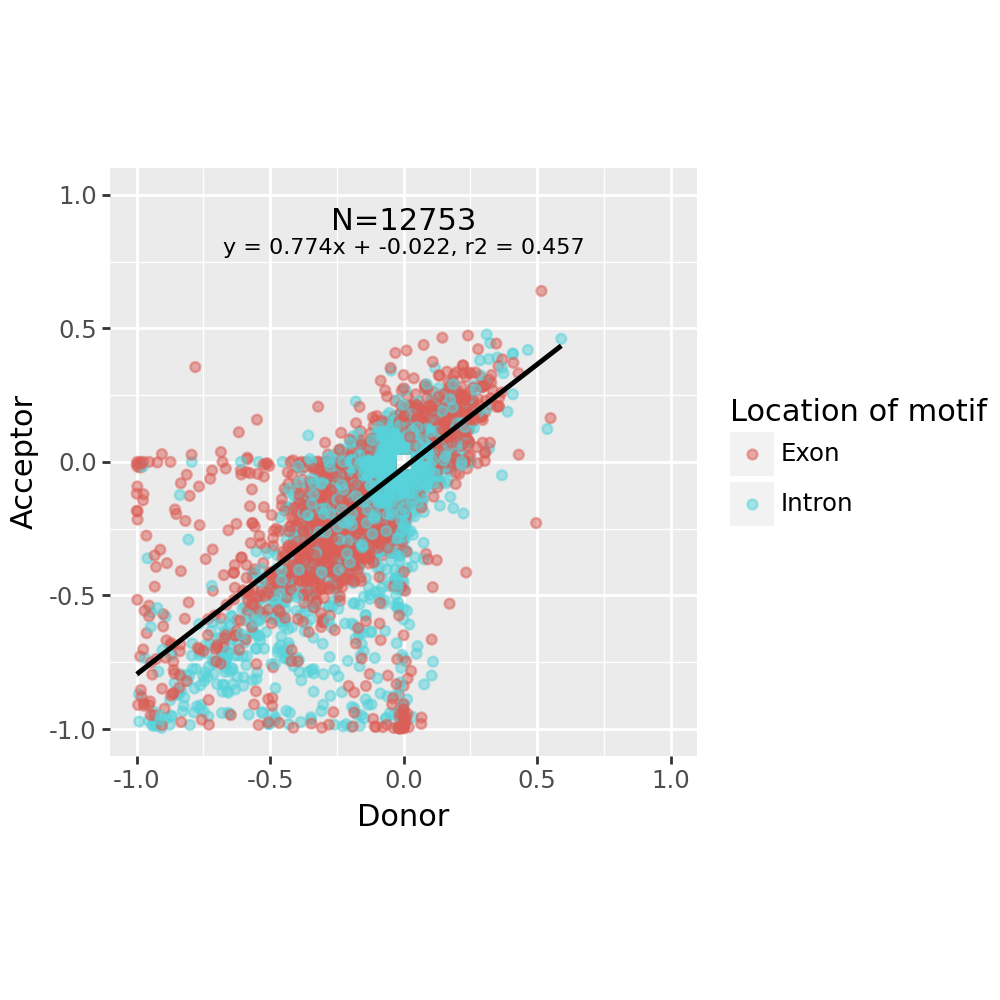

In [319]:
_cass = cass[cass.cass_diff]
plotDonorAndAcceptorCorrelation(_cass)

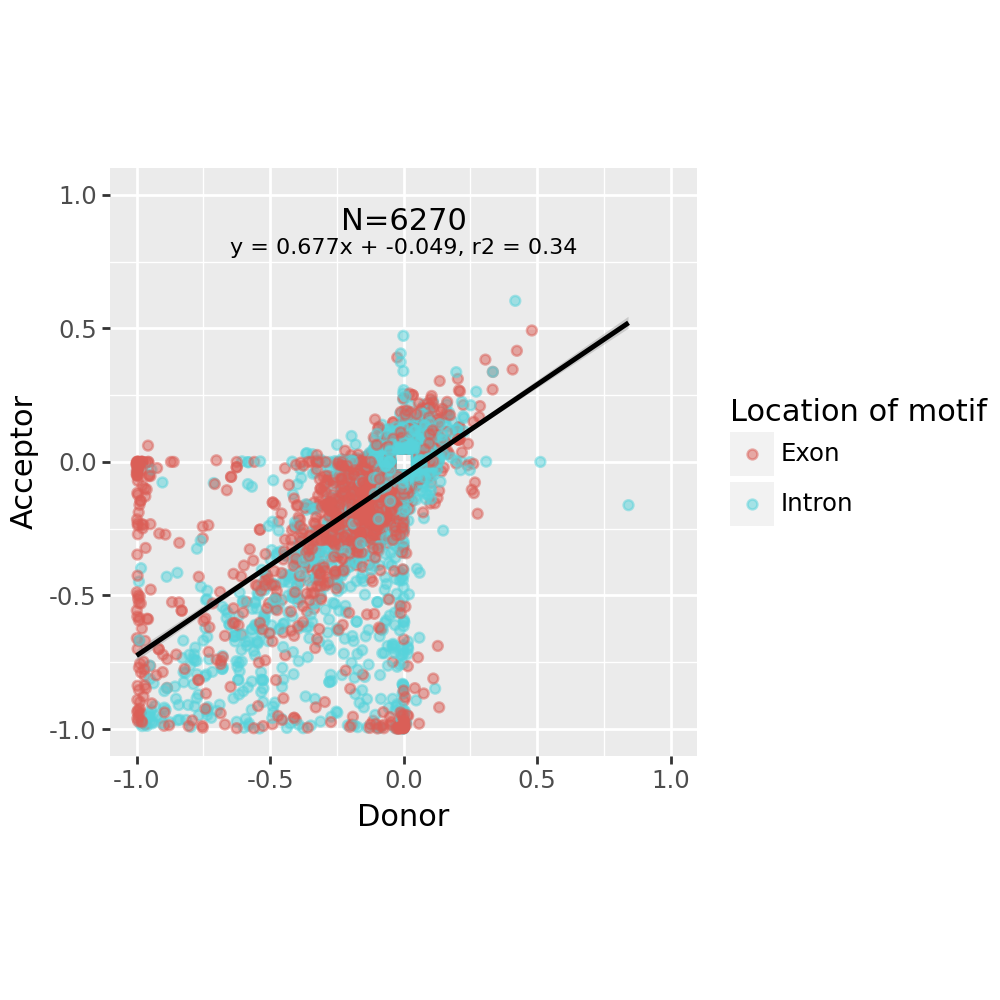

In [320]:
plotDonorAndAcceptorCorrelation(cass_ctrl[cass_ctrl.cass_diff])

/tmp/ipykernel_2740566/2829376376.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


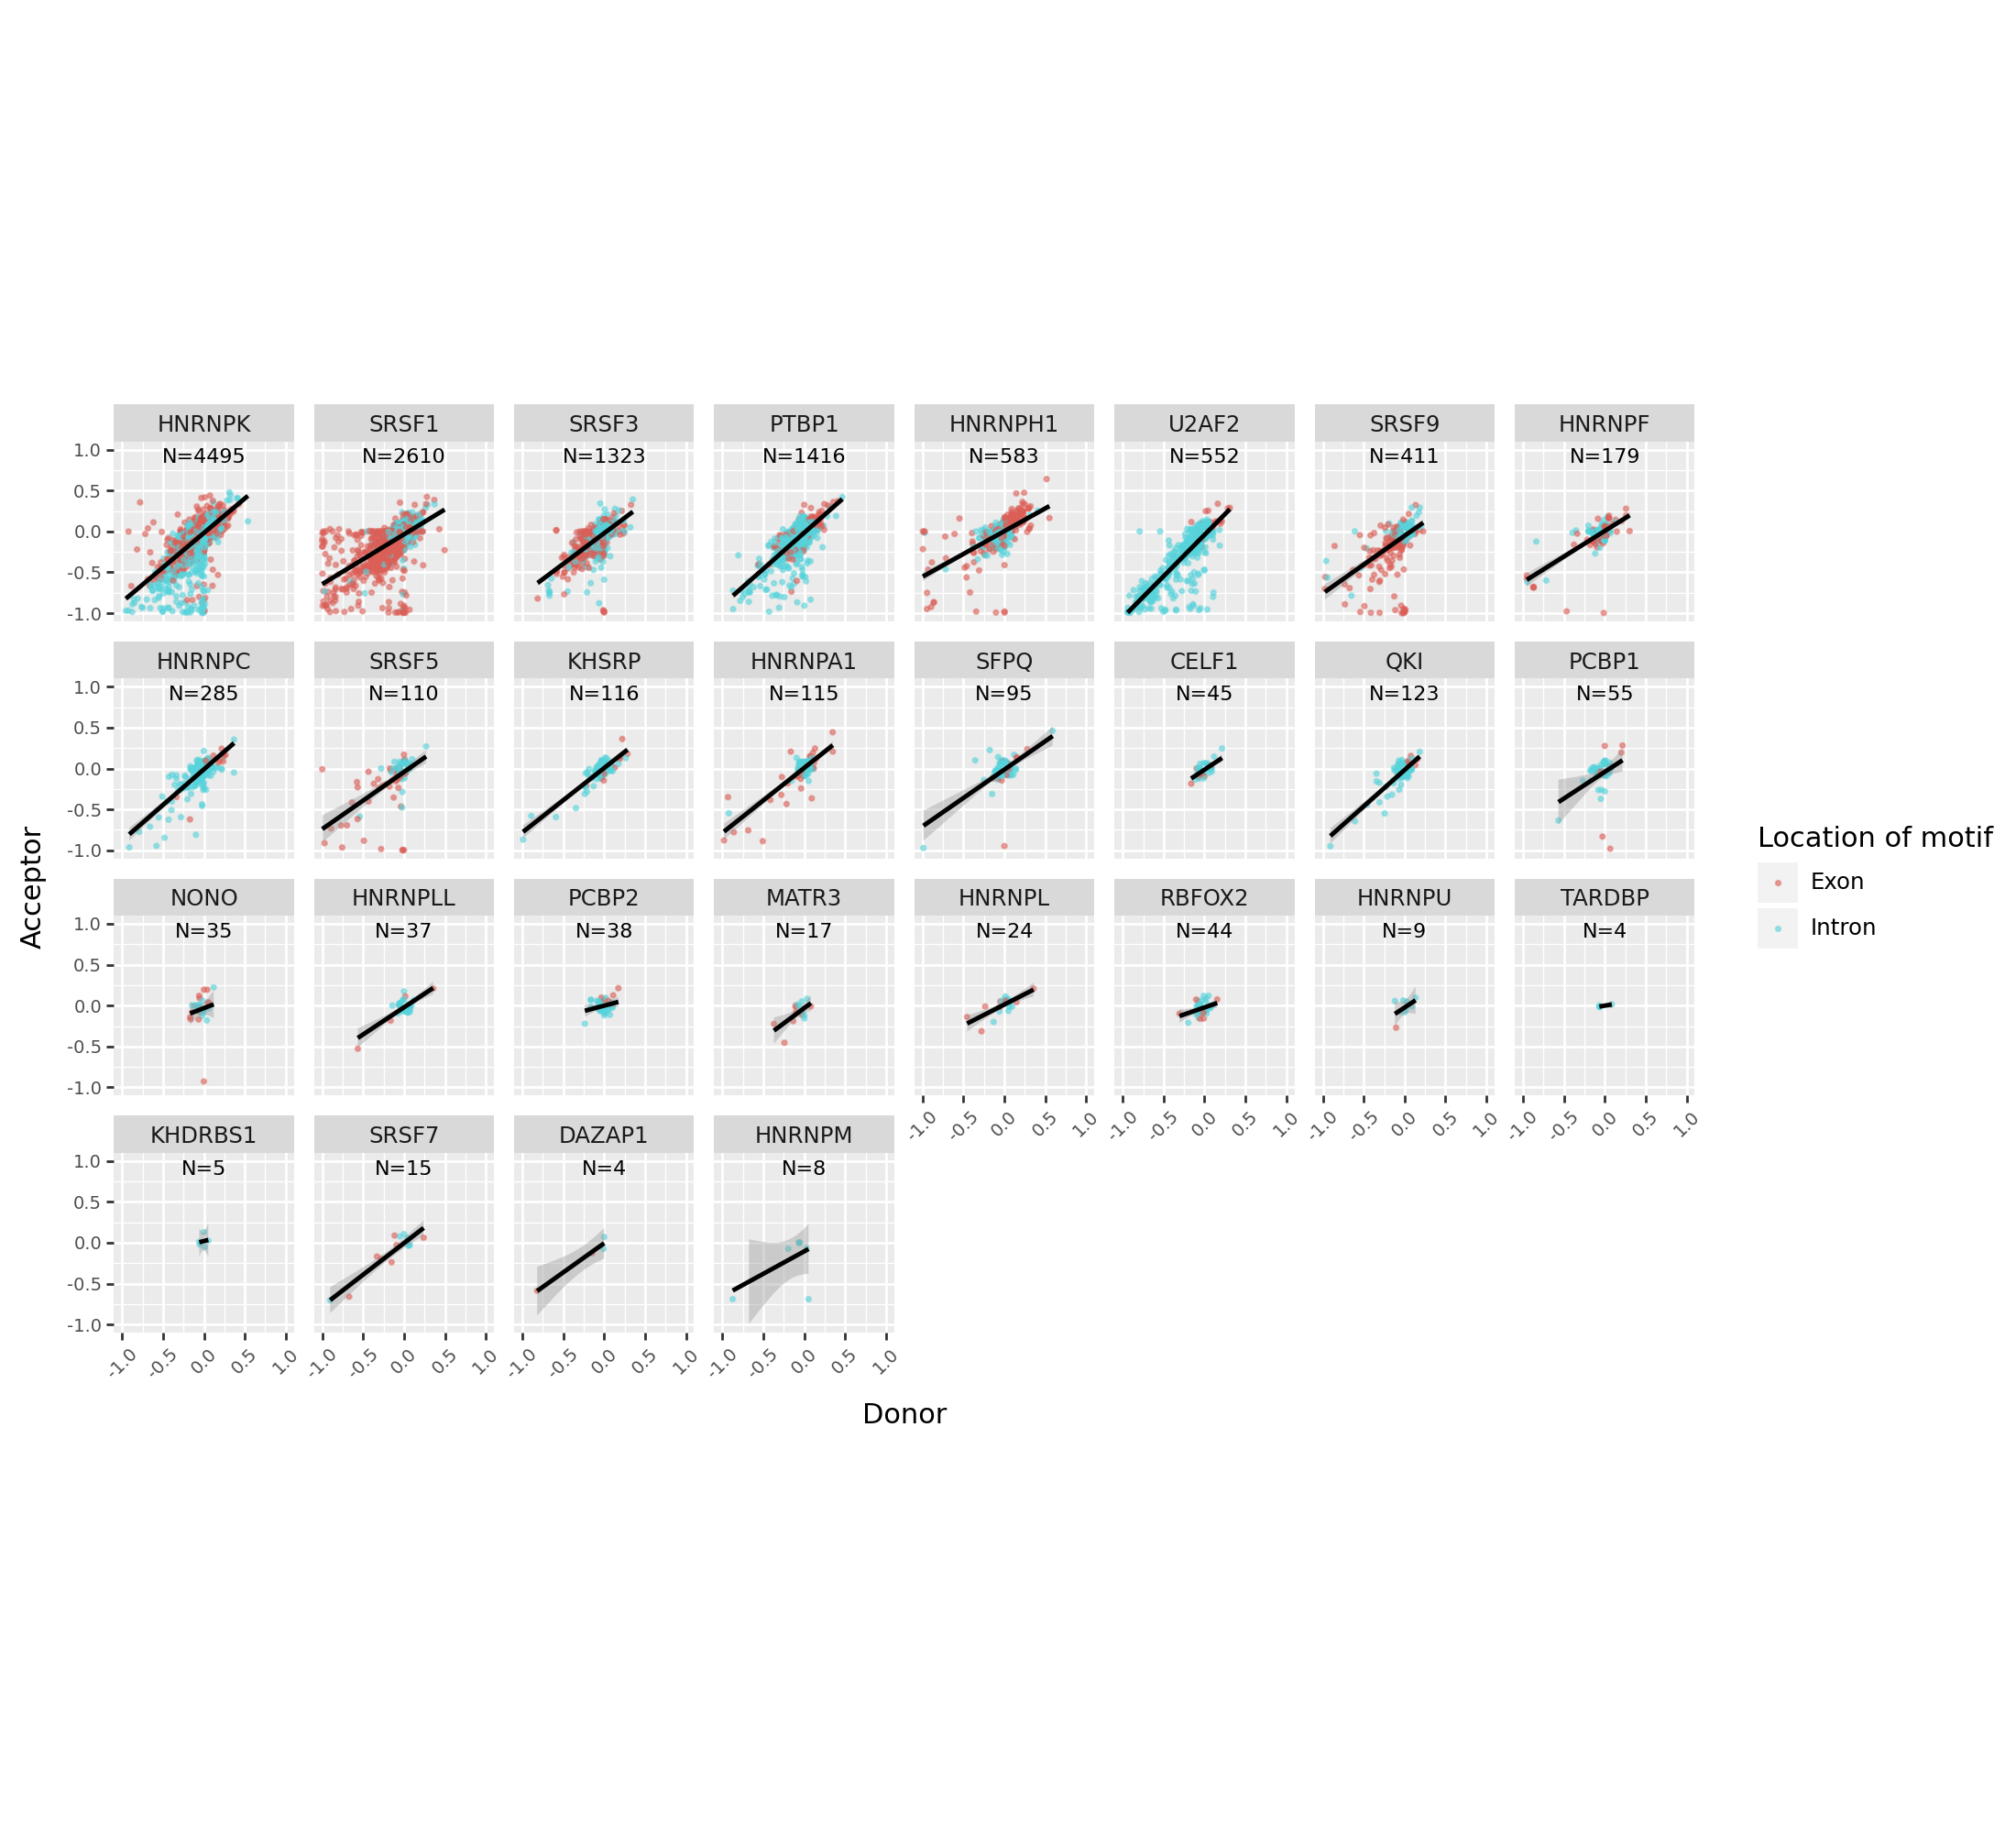

In [321]:
plotDonorAndAcceptorCorrelation(_cass, per_rbp=True)

/tmp/ipykernel_2740566/2829376376.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
/home/pbarbosa/miniconda3/envs/mutsplice/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_smooth : Removed 8 rows containing missing values.


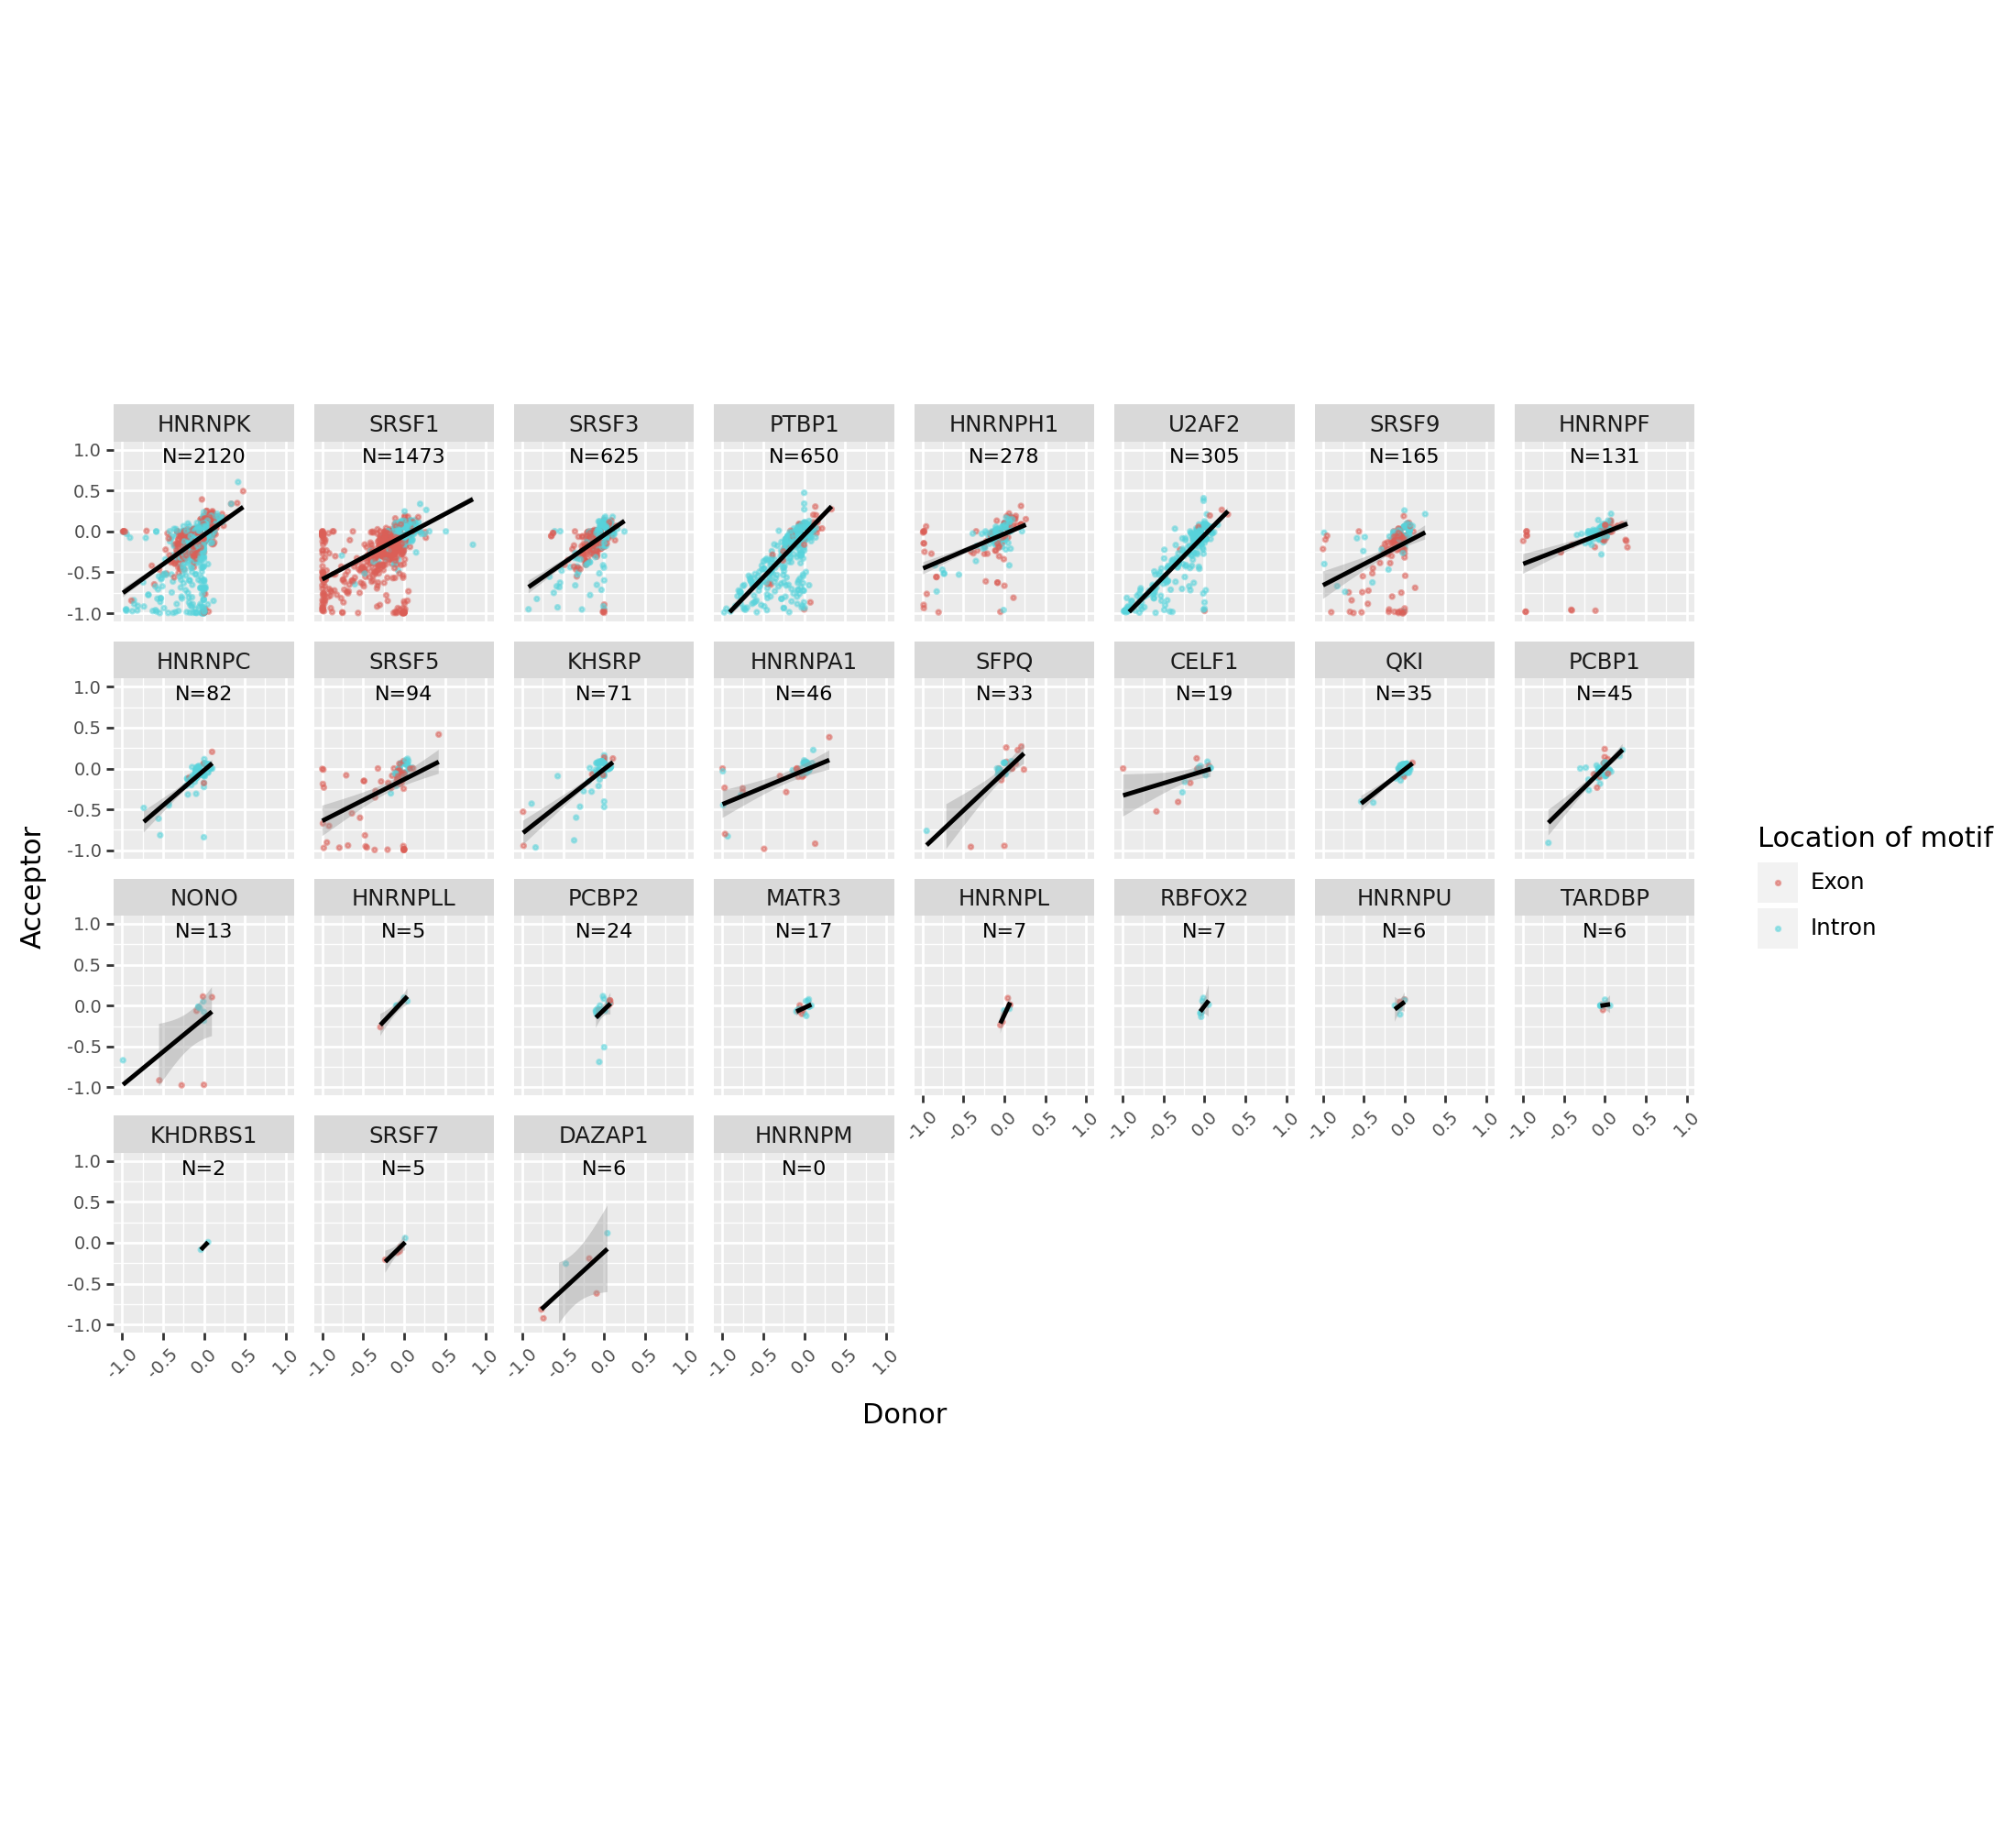

In [322]:
plotDonorAndAcceptorCorrelation(cass_ctrl[cass_ctrl.cass_diff], per_rbp=True)

#### Plots on the distribution of motif effects

In [172]:
def plotMotifEffectDistributionMultipleRBPs(cass: pd.DataFrame, rbps: list = None):
    cass_filt = cass.copy()
    cass_filt.is_in_exon = cass.is_in_exon.replace({True: "Exon", False: "Intron"})
    cass_filt = cass_filt.rename(columns={"is_in_exon": "Location of motif"})

    # Change signed values to represent effect of motifs in spliceAI preds
    cass_filt["mutation_effect"] = cass_filt.mutation_effect * (-1)
    cass_filt = cass_filt[
        (cass_filt.mutation_effect <= -0.05) | (cass_filt.mutation_effect >= 0.05)
    ]

    # rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK', 'U2AF2', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']
    if rbps:
        cass_filt = cass_filt[cass_filt.rbp_name.isin(rbps)]

    cass_filt["Location of motif"] = pd.Categorical(
		cass_filt["Location of motif"], categories=["Exon", "Intron"]
	)
    palette = {"Exon": "teal", "Intron": "orange"}
    f, (ax1, ax2) = plt.subplots(figsize=(9, 7), ncols=2, nrows=1, sharey=True)
    ax1 = sns.violinplot(
        x="mutation_effect",
        y="rbp_name",
        hue="Location of motif",
        palette=palette,
        inner=None,
        split=True,
        data=cass_filt,
        linewidth=0.5,
        ax=ax1,
    )
    ax2 = sns.violinplot(
        x="mutation_effect",
        y="rbp_name",
        hue="Location of motif",
        palette=palette,
        inner=None,
        split=True,
        data=cass_filt,
        linewidth=0.5,
        ax=ax2,
    )

    ax1.set_xlim(-1, -0.05)
    ax2.set_xlim(0.05, 1)
    
    sns.despine(ax=ax1, left=True)
    sns.despine(ax=ax2, left=True)

    plt.subplots_adjust(wspace=0.01)
    ax1.set_xlabel("")
    ax1.set_ylabel("")

    ax2.set_xlabel("")
    ax2.set_ylabel("")

    ax1.legend_.remove()
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05])
    ax1.tick_params(axis="x", labelsize=12, rotation=45)
    ax1.tick_params(axis="y", labelsize=12)

    ax1.axvline(-0.05, color="k", ls="--")
    ax2.axvline(0.05, color="k", ls="--")
    ax2.set_xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.tick_params(axis="x", labelsize=12, rotation=45)
    f.supxlabel("Motif effect on SpliceAI prediction", size=15)
    plt.tight_layout()

In [173]:
def plotMotifEffectDistribution(cass: pd.DataFrame, rbp: str):
	sns.set_style("white")
 
	# Plot only relevant changes
	cass_filt = cass[(cass.mutation_effect <= -0.05) | (cass.mutation_effect >= 0.05)]
	cass_filt = cass.copy()

	# Change signed values to represent effect of motifs in spliceAI preds
	cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)

	cass_filt=cass_filt[cass_filt.rbp_name == rbp]
	cass_filt.is_in_exon = cass.is_in_exon.replace({True: 'Exon', False: 'Intron'})
	cass_filt.is_in_exon = pd.Categorical(cass_filt.is_in_exon, ['Exon', 'Intron'])
	cass_filt = cass_filt.rename(columns={'is_in_exon': 'Location of motif'})

	fig, ax = plt.subplots(figsize=(6, 4))
	ax = sns.violinplot(data=cass_filt,
				x='mutation_effect',
				y='rbp_name', 
				hue='Location of motif',
				split=True,
				palette={'Exon': 'teal', 'Intron': 'orange'},
				density_norm='area', 
				common_norm=True,
				orient='h',
				inner=None)

	ax.axvline(-0.05, color='k', ls='--')
	ax.axvline(0.05, color='k', ls='--')
	a=1
	ax.tick_params(axis='both', which='major', labelsize=10)
	plt.xlabel('Motif effect on SpliceAI prediction', size=12)
	plt.ylabel('')
	plt.tight_layout()

In [174]:
import matplotlib.patches as mpatches
def plotMotifEffectHistogram(cass: pd.DataFrame, rbp: str):
    cass_filt = cass.copy()
    
    # Change signed values to represent effect of motifs in SpliceAI preds
    cass_filt['mutation_effect'] = cass_filt.mutation_effect * (-1)
    cass_filt=cass_filt[cass_filt.rbp_name == rbp]
    cass_filt.is_in_exon = cass.is_in_exon.replace({True: 'Exon', False: 'Intron'})
    cass_filt = cass_filt.rename(columns={'is_in_exon': 'Location of motif'})

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(4, 3))

    _values=cass_filt[cass_filt.mutation_effect.abs() > 0.05]
    bins = np.arange(-1,1, 0.05)
    hist_i, _ = np.histogram(_values[_values['Location of motif'] == 'Intron'].mutation_effect, bins=bins)
    hist_e, _ = np.histogram(_values[_values['Location of motif'] == 'Exon'].mutation_effect, bins=bins)
    ymax = max(max(hist_i), max(hist_e))

    for ax, location, color, invert in zip(axes.ravel(), ['Exon', 'Intron'], ['teal', 'orange'], [False,True]):
        values=cass_filt[cass_filt['Location of motif'] == location].mutation_effect
        values=values[values.abs() > 0.05]
        
        kwargs = dict(histtype='stepfilled', alpha=0.8, density=False, edgecolor="black", linewidth=0.5)
        ax.hist(values, bins=bins, color=color, **kwargs)

        ax.text(0.1, 0.8 if location == 'Exon' else 0.8, f'N={len(values)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
        ax.set_xlim(-1, 1)
        ax.set_ylim(0, ymax + 5)
        ax.axvline(-0.05, color='k', linewidth=0.8, ls='--')
        ax.axvline(0.05, color='k', linewidth=0.8, ls='--')
        ax.set_yticks([])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.fill_betweenx(np.arange(0, ymax, 0.1), -0.05, 0.05, color='floralwhite', alpha=1)
        if invert:
            ax.invert_yaxis()
            ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1])
            ax.xaxis.set_ticks_position('bottom') 
            ax.spines['top'].set_color('black') 
            ax.spines['top'].set_linewidth(1)
            ax.spines['bottom'].set_color('black') 
            ax.spines['bottom'].set_linewidth(0.75) 
            ax.tick_params(axis='x', labelsize=10, width=0.5, pad=1, length=2,rotation=45)
        else:
            exon_patch = mpatches.Patch(color='teal', alpha=0.8, label='Exon')
            intron_patch = mpatches.Patch(color='orange', alpha=0.8, label='Intron')
            legend = ax.legend(handles=[exon_patch, intron_patch], edgecolor='k', prop={'size': 9}, frameon=False)

        ax.set_facecolor('white')
        ax.patch.set_linewidth(1)
    
    fig.supylabel(rbp, y=0.525, rotation=0, size=11)
    plt.subplots_adjust(hspace=0)
    fig.patch.set_alpha(0)

    _ = plt.xlabel('Motif effect on spliceAI prediction', size=11)
    plt.savefig(f'plots/3_mutsplice_motif_effects_dist_{rbp}.pdf', bbox_inches = "tight")

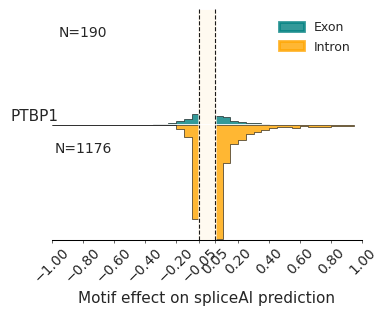

In [175]:
rbps = ['HNRNPA1','HNRNPC','HNRNPF','HNRNPH1','HNRNPK', 'U2AF2', 'PTBP1','SRSF1','SRSF3','SRSF5','SRSF9']
rbp = 'PTBP1'
#for rbp in rbps:
plotMotifEffectHistogram(cass, rbp)

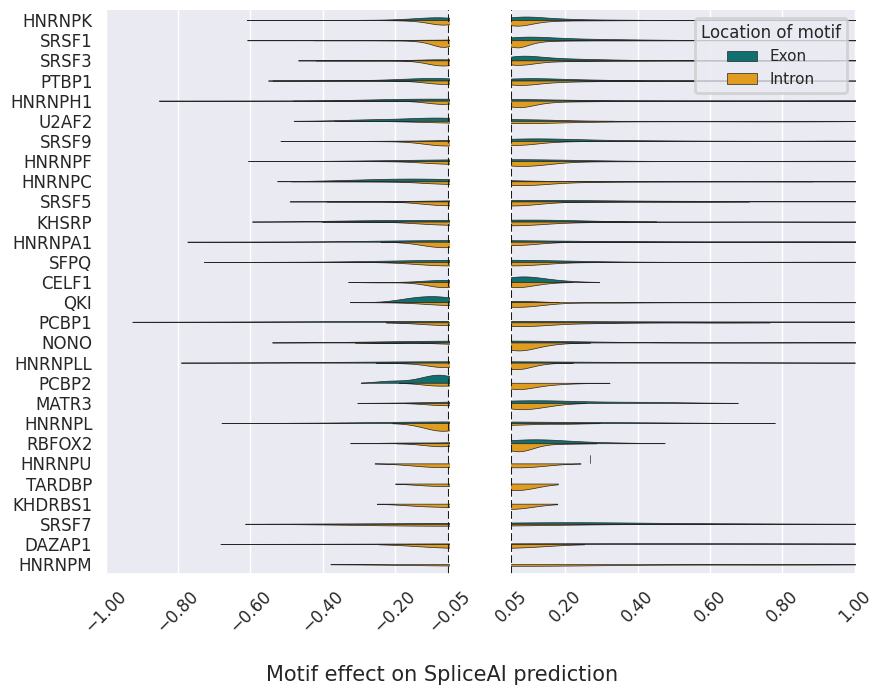

In [176]:
plotMotifEffectDistributionMultipleRBPs(cass)

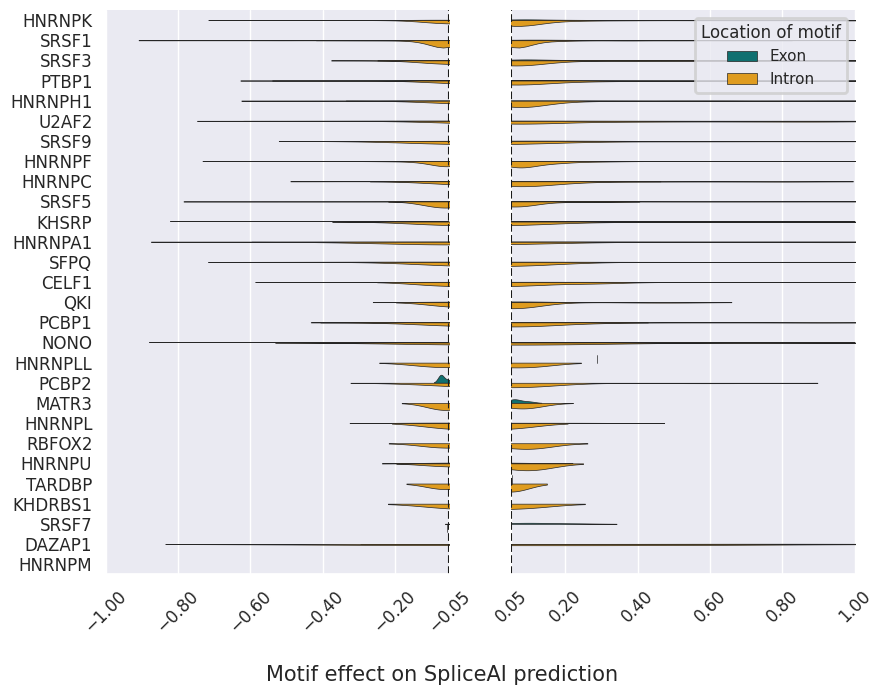

In [177]:
plotMotifEffectDistributionMultipleRBPs(cass_ctrl)

In [215]:
effect_df_ = deletions.copy()
effect_df_['any_diff'] = effect_df_[effect_cols].abs().gt(0.2).any(1)
effect_df = effect_df_[effect_df_.any_diff][effect_cols + ['Location', 'Is_in_exon', 'rbp_name']]
effect_df.columns = [col.replace("_effect", "") for col in effect_df.columns] 
ordered_effects = ['Acceptor_Upstream', 'Donor_Upstream', 'Acceptor_Cassette', 'Donor_Cassette', 'Acceptor_Downstream', 'Donor_Downstream']

In [ ]:
# calculate the correlation matrix
corr = effect_df[ordered_effects].corr()
sns.set(font_scale = 1)
cm = sns.heatmap(corr, 
                 linecolor='black',
                 linewidths=0.1,
                 cbar=True,
                 annot=True,
                 xticklabels=1,
                 fmt='.2f',
                 cmap=sns.color_palette("Blues", as_cmap=True))
plt.tight_layout()
plt.savefig('effects_correlation.pdf')

#### Compare mutation effects between groups

In [354]:
import statsmodels
from scipy.stats import mannwhitneyu
def plotPerturbationEffectBetweenGroups(data: pd.DataFrame):

    pvals = data.groupby('rbp_name_with_N').apply(lambda x: mannwhitneyu(x[x.exon_group == "CTRL"]['mutation_effect'],
                                                                    x[x.exon_group == "KD"]['mutation_effect']).pvalue)

    pval_corrected = statsmodels.stats.multitest.multipletests(pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)[0]
    is_sign_df = pd.DataFrame({'rbp_name_with_N': pvals.index, 'is_sign': pval_corrected}).replace({True: "*", False: 'ns'})
    data = pd.merge(data, is_sign_df, on='rbp_name_with_N')

    #########################
    fig, ax = plt.subplots(figsize=(6, 8))
    palette={'KD': 'burlywood', 'CTRL': 'gray'}

    # Sort RBPs by the number of motifs
    data['rbp_name_with_N'] = pd.Categorical(data.rbp_name_with_N, 
                                            categories=data.groupby('rbp_name_with_N').size().sort_values(ascending=False).index, 
                                            ordered=True)

    ax = sns.violinplot(data=data,
                y='rbp_name_with_N',
                x='mutation_effect', 
                hue='exon_group',
                dodge=False, 
                split=True, 
                orient='h',
                linewidth=0.025,
                palette=palette,
                inner='box')

    #Add statistical sign to the figure
    pos = range(is_sign_df.shape[0])
    for tick, label in zip(pos, ax.get_yticklabels()):
        ax.text(1, 
                pos[tick],
                is_sign_df[is_sign_df.rbp_name_with_N == label.get_text()].iloc[0].is_sign,
                horizontalalignment='center',
                fontdict=dict(fontsize=12))

    plt.xlabel('Mutation effect', size=15)
    plt.ylabel('')
    plt.tight_layout()

In [384]:
_DATA = DATA.copy()
_DATA = pd.merge(_DATA, counts_per_rbp[['rbp_name', 'rbp_name_with_N']], on='rbp_name')
_DATA = _DATA[~_DATA.rbp_name.isin(counts_per_rbp[counts_per_rbp.total_counts < 50].rbp_name)]

/tmp/ipykernel_2740566/1200396411.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


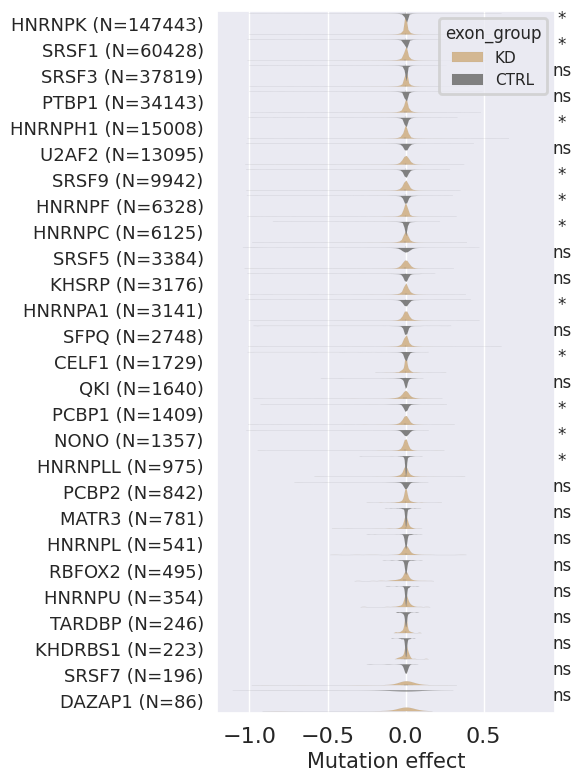

In [373]:
plotPerturbationEffectBetweenGroups(_DATA)	

In [402]:
def plotFractionOfMeaningfullEffects(data: pd.DataFrame, rbps: list = None):
    
    data['mutation_effect'] = data['mutation_effect'].abs()
    cass_5pct = data.query('mutation_effect >= 0.05')
    pct_df = cass_5pct.groupby(['rbp_name_with_N', 'exon_group']).size() / data.groupby(['rbp_name_with_N', 'exon_group']).size() * 100
    pct_df = pct_df.reset_index().rename(columns={0: 'frac'})
    pct_df = pd.merge(pct_df, data[['rbp_name_with_N', 'rbp_name']].drop_duplicates(), on='rbp_name_with_N')
    pct_df['thresh'] = '>5%'

    if rbps:
        pct_df = pct_df[pct_df.rbp_name.isin(rbps)]

    palette={'KD': 'burlywood', 'CTRL': 'gray'}
    ax = sns.catplot(data=pct_df.sort_values('rbp_name'), kind="bar",
                    x="frac", y="rbp_name_with_N", hue="exon_group", linewidth=0.5, palette=palette, alpha=.8, height=8, aspect=1
    )

    ax.set_titles("{col_name}").despine(left=True)
    ax.set_axis_labels("% of mutations with meaningful effect", "")
    ax.legend.set_title("")

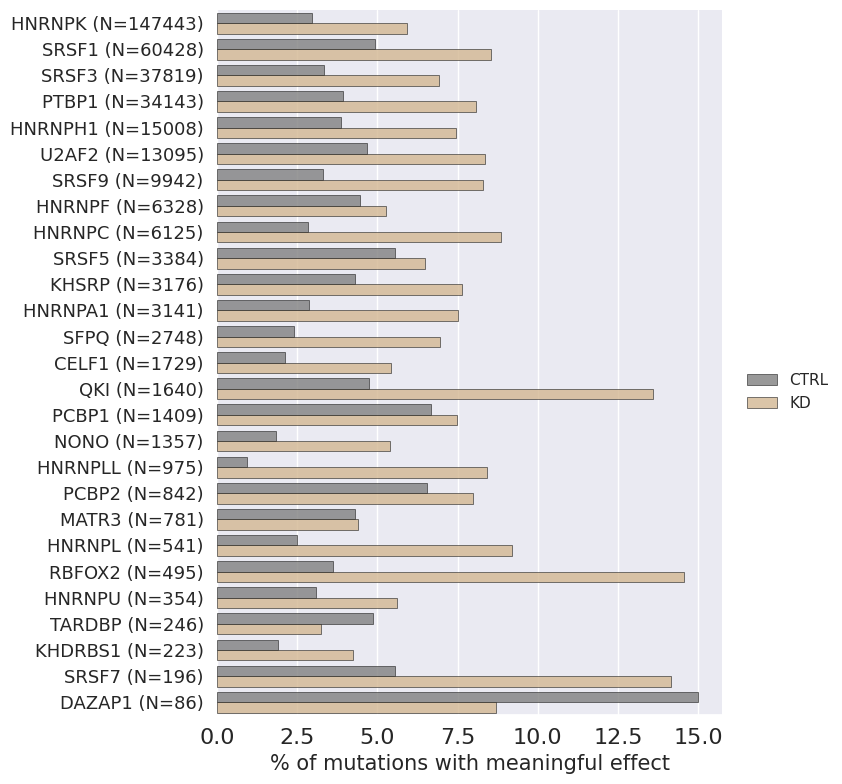

In [403]:
_DATA['rbp_name'] = _DATA['rbp_name'].astype(pd.CategoricalDtype(categories=DATA['rbp_name'].cat.categories, ordered=True))
plotFractionOfMeaningfullEffects(_DATA)	

### Correlation between RNA-Seq and SpliceAI 

In [38]:
# MAP OF SpliceAI IDs to original Exon Coordinates
spliceAI_Seqs_To_ExonCoords = pd.read_csv('/Users/pbarbosa/Desktop/NFS_Pedro/phd/rbp_data/HepG2/splicing_related/FINAL_RNA_SEQ_dPSIs_PER_SpliceAI_seq.tsv.gz', sep="\t").rename({'exon_coord': 'target_coordinates'}, axis=1)

In [39]:
_cass = cass[cass.cass_diff][['rbp_name', 'target_coordinates', 'donor_cassette_effect', 'acceptor_cassette_effect']]
_cass['pred_dPSI'] = np.mean(_cass[['donor_cassette_effect', 'acceptor_cassette_effect']], axis=1)

_cass['pred_dPSI'] = _cass[['donor_cassette_effect', 'acceptor_cassette_effect']].apply(lambda x: x[np.argmax(np.abs(x))], axis=1)

In [40]:
df = pd.merge(_cass, spliceAI_Seqs_To_ExonCoords, on=['target_coordinates', 'rbp_name'])

# When multiple mutsplice observations for a given exon, select the closest to the real dPSI
df = df.groupby(['rbp_name', 'target_coordinates', 'dPSI']).apply(lambda x: x.loc[(x.dPSI - x.pred_dPSI).abs().idxmin()]).reset_index(drop=True)

In [41]:
p2 = (ggplot(df, aes(x='dPSI', y='pred_dPSI')) +
        geom_point(alpha = 0.5)
)

In [ ]:
 p2 = (ggplot(df, aes(x='dPSI', y='pred_dPSI')) +
        geom_point(alpha = 0.5) + 
        #geom_smooth(se=True, method="lm", color="black") +
        facet_wrap('rbp_name', ncol=8) + 
        theme(figure_size=(16, 13)))

## Analysis based on location

### Using rows with any effect

In [216]:
effect_tidy = effect_df.melt(id_vars=['Location', 'Is_in_exon', 'rbp_name'], var_name='Effect', value_name='SpliceAI_diff')
effect_tidy_cass = effect_tidy[effect_tidy.Effect.str.contains('Cassette')]

In [ ]:
hue_order=['Intron_Upstream_2', 'Exon_upstream_acceptor_region', 'Exon_upstream_full_span', 'Exon_upstream_fully_contained', 'Exon_upstream_donor_region', 
           'Intron_Upstream', 'Exon_cassette_acceptor_region', 'Exon_cassette_fully_contained', 'Exon_cassette_donor_region', 'Intron_Downstream',
           'Exon_downstream_acceptor_region', 'Exon_downstream_fully_contained', 'Exon_downstream_donor_region', 'Intron_Downstream_2']
#fig, ax = plt.subplots(figsize=(18, 12))
#g = sns.factorplot("id","num_mutations",data=grouped_samples, order=id_list, kind="box", size=7, aspect=3, palette=organ_palette)
sns.set(font_scale = 4)
pallette=['dodgerblue4', 'deepskyblue2', 'darkslategray3', 'darkslategray1', 'darkslategray4', 
          'darkgoldenrod3', 'cornsilk1', 'cornsilk3', 'cornsilk4', 'darkgoldenrod4',
         'rosybrown2', 'salmon', 'red4', 'red2', 'red3']

pallette=['#104E8B', '#00B2EE', '#79CDCD', '#97FFFF', '#528B8B', 
          '#CD950C', '#FFF8DC', '#CDC8B1', '#8B8878', '#8B6508',
          '#EEB4B4', '#FA8072', '#8B0000',  '#CD0000', '#EE0000']


#sns.catplot(x='Bill_Name', y='counts', hue='Reason',row='year', data=data, kind='bar', height=6, aspect=13/6, legend=True, palette='hls')
def plot_loc(df: pd.DataFrame):
    try:
        name = df.name
    except:
        name = "All"
        
    sns.catplot(x="Effect", y="SpliceAI_diff",
                hue='Location', 
                #col='rbp_name', 
                #col_wrap=5,
                hue_order=hue_order,
                kind='box', 
                legend_out=True, 
                height=10, 
                aspect=4, 
                palette=pallette, 
                data=df)


    plt.savefig('{}_location.pdf'.format(name), bbox_inches='tight')
    plt.close()
    
plot_loc(effect_tidy_cass)
effect_tidy_cass.groupby('rbp_name').apply(plot_loc)
# WITH FACET GRID
# g = sns.FacetGrid(effect_tidy, col='Effect',col_order=ordered_effects, col_wrap=2, sharex=True, sharey=True, height=8)
# g.map(sns.boxplot, 'SpliceAI_diff', 'Location', whis=(1,99), palette='muted')

### Using all rows for a distance-based meta analysis

In [662]:
# Distances info for cassette exons in tidy format
def distanceInfoToTidy(df: pd.DataFrame,
                       exon: str = 'Cassette'):
    """
    Given an input df (filtered at any level),
    generates ouput df in tidy format for 
    downstream plotting
    """
    melt1 = df.melt(id_vars=['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name'], 
                           value_vars=['Distance_to_donor', 'Distance_to_acceptor'], var_name = 'SpliceSite', value_name = 'Distance')

    melt2 = df.melt(id_vars=['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name'], 
                           value_vars=['Donor_{}_effect'.format(exon), 'Acceptor_{}_effect'.format(exon)], var_name = 'EffectOn', value_name = 'dPSI')

    melt1 = melt1.set_index(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name', melt1.groupby(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name']).cumcount()])
    melt2 = melt2.set_index(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name', melt2.groupby(['id', 'seq_id', 'Is_in_exon', 'Location', 'rbp_name']).cumcount()])

    dist_melt = pd.concat([melt1, melt2], axis=1).sort_index(level=5).reset_index(level=5, drop=True).reset_index()
    dist_melt['SpliceSite'] = dist_melt.SpliceSite.str.replace('Distance_to_', '').str.title()
    dist_melt['EffectOn'] = dist_melt.EffectOn.str.replace('_{}_effect'.format(exon), '')
    dist_melt['Distance'] = dist_melt.Distance.astype('Int64', errors='ignore')
    
    return dist_melt


def createDistanceBin(df: pd.DataFrame, n_bins:int):
    """
    From a df in tidy format, creates an
    additional column representing the 
    distance bin a given mutation is located
    """   
    #df['DistanceBin'] = pd.qcut(df['Distance'], np.arange(0, 1.05, 0.05), duplicates='drop') 
    df['DistanceBin'] = pd.qcut(df['Distance'], n_bins, duplicates='drop') 
    if df.DistanceBin.isna().any():
        return None
    elif df.DistanceBin.isna().any():
        print("BAH")
        print(df)
    else:
        return df


def calculateStats(df: pd.DataFrame):
    """
    Calculates overall stats and confidence intervals
    for the dPSI changes caused by a mutation 
    at given distance bin to splice donors and acceptors
    
    :param pd.DataFrame: Df in tidy format
    """
    if df.empty:
        return df

    stats = df.drop(columns=['Distance']).groupby(['EffectOn', 'SpliceSite', 'DistanceBin', 'Is_in_exon']).agg(['mean', 'count', 'std']).dropna()
    #stats = df.drop(columns=['Distance', 'Is_in_exon']).groupby(['EffectOn', 'SpliceSite', 'DistanceBin']).agg(['mean', 'count', 'std']).dropna()
  
    ci95_up = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_up.append(m + 1.95*s/math.sqrt(c))
        ci95_lo.append(m - 1.95*s/math.sqrt(c))

    stats['ci95_upper'] = ci95_up
    stats['ci95_lower'] = ci95_lo
    stats = stats.reset_index()
    stats.columns = ['{}_{}'.format(x, y) if x == "dPSI" else '{}'.format(x) for x, y in stats.columns.to_flat_index()]
    
    return stats

In [687]:
def run_all(df: pd.DataFrame, split_pos_neg_dPSI: bool, only_sign_dPSI: bool, n_bins: int, name: str):

    if only_sign_dPSI:
        df = df[(df.dPSI > 0.1) | (df.dPSI < - 0.1)]

    # EXONS
    df_exons = df[df.Is_in_exon]

    df_exons_donor_effects = df_exons[df_exons.SpliceSite == "Donor"]
    df_exons_donor_effects = createDistanceBin(
        df_exons_donor_effects, n_bins=n_bins)
    df_exons_acceptor_effects = df_exons[df_exons.SpliceSite == "Acceptor"]
    df_exons_acceptor_effects = createDistanceBin(
        df_exons_acceptor_effects, n_bins=n_bins)

    # INTRONS
    df_introns = df[~df.Is_in_exon]
  
    df_introns_donor_effects = df_introns[df_introns.SpliceSite == "Donor"]
    df_introns_donor_effects_upstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.Location == "Intron_Upstream"], n_bins=n_bins)
    df_introns_donor_effects_downstream = createDistanceBin(
        df_introns_donor_effects[df_introns_donor_effects.Location == "Intron_Downstream"], n_bins=n_bins)

    df_introns_acceptor_effects = df_introns[df_introns.SpliceSite == "Acceptor"]
    df_introns_acceptor_effects_upstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.Location == "Intron_Upstream"], n_bins=n_bins)
    df_introns_acceptor_effects_downstream = createDistanceBin(
        df_introns_acceptor_effects[df_introns_acceptor_effects.Location == "Intron_Downstream"], n_bins=n_bins)

    ###############
    #### STATS ####
    ###############
    def _init_empty_df():
        return pd.DataFrame(columns=['id', 'seq_id', 'Is_in_exon', 'Location',
                                      'rbp_name', 'SpliceSite', 'Distance',
                                      'EffectOn', 'dPSI', 'DistanceBin'])
        
    info = [df_introns_donor_effects_upstream, df_exons_donor_effects, df_introns_donor_effects_downstream,
            df_introns_acceptor_effects_upstream, df_exons_acceptor_effects, df_introns_acceptor_effects_downstream]
    
    donors_out, acceptors_out = [], []

    for idx, v in enumerate(info):
 
        if v is None:
            v = _init_empty_df()         
   
        if split_pos_neg_dPSI:
                
            pos = v[v.dPSI >= 0]
            if not pos.empty:
                pos = calculateStats(pos)

            neg = v[v.dPSI <= 0]
            if not neg.empty:
                neg['dPSI'] = neg.dPSI.abs()
                neg = calculateStats(neg)

            donors_out.extend([pos, neg]) if idx < 3 else acceptors_out.extend([pos, neg])
            
        else:
            v['dPSI'] = v.dPSI.abs()
            donors_out.append(calculateStats(v)) if idx < 3 else acceptors_out.append(calculateStats(v))

    plotDistanceMetaProfile(ss='donor',
                            data=donors_out,
                            split_pos_neg_dPSI=split_pos_neg_dPSI)
    plt.savefig('{}_metaprofile_donors.pdf'.format(name), bbox_inches='tight')
    plt.close()

    plotDistanceMetaProfile(ss='acceptor',
                            data=acceptors_out,
                            split_pos_neg_dPSI=split_pos_neg_dPSI)
    plt.savefig('{}_metaprofile_acceptors.pdf'.format(
        name), bbox_inches='tight')
    plt.close()


In [657]:
###################
## ggplot2 like ###
###################
#p1 = (ggplot(stats_sign_introns_donor_effects_downstream, aes(x = 'Distance', y = 'dPSI_mean')) +
#      geom_line(group='ignored') + 
#      geom_ribbon(aes(ymin = 'ci95_lower', ymax = 'ci95_upper', fill = 'SpliceSite'), alpha = 0.5, group='ignored') +
#      theme(figure_size=(16, 8))
#     )

#p1

#####################
## Seaborn-based. ###
##################### 
# Can plot directly from original dataframes. 
# No need to calculate stats. However, it will do bootstrapping to calculate CI
# test = sign_df_introns_donor_effects_upstream.copy()
# test['Distance'] = test.DistanceBin.apply(lambda x: np.ceil(x.mid).astype(int))
# fig, ax = plt.subplots(figsize=(9,5))
# sns.lineplot(data=test, x="Distance", y="dPSI", ci='sd')
# sns.despine()
# plt.show()

##########################
##### PURE MATPLOTLIB ####
##########################
from matplotlib.offsetbox import AnchoredText
import matplotlib.lines as mlines

def plotDistanceMetaProfile(ss: str, data: list, split_pos_neg_dPSI: bool):
    
    def _common_plot_attributes():
        ax.set_xlabel('Distance Bin', fontsize=20)
        ax.tick_params(axis='x', labelsize=15)
        
        ax.set_ylabel('SpliceAI variation', fontsize=20)
        ax.tick_params(axis='y', labelsize=15)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.set_tick_params(labelbottom=True)
        
        plt.xticks(rotation=45)
        ax.tick_params(axis='x', labelrotation=45)
        
        
    sns.set(font_scale=1)
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10,6))

    if split_pos_neg_dPSI:

        dpsi_neg = data[1::2] 
        dpsi_pos = data[::2]

        for i, ax in enumerate([ax1, ax2, ax3]):
            as_categorical_x_axis = True
            leg_handles = []
            try:
                pos_eff = dpsi_pos[i].copy()
            except AttributeError:
                pos_eff = None
            
            try:
                neg_eff = dpsi_neg[i].copy()
            except AttributeError:
                neg_eff = None
            
            # Fix absent bins when there's dat afor both pos and neg dPSI variations
            if all(x is not None and not x.empty for x in [pos_eff, neg_eff]):
                neg_bin_missing = set(pos_eff.DistanceBin).difference(neg_eff.DistanceBin)
                pos_bin_missing = set(neg_eff.DistanceBin).difference(pos_eff.DistanceBin)
                
                if any(len(x) for x in [pos_bin_missing, neg_bin_missing]):
                    as_categorical_x_axis = False
                    #neg_eff['dPSI_mean'] = neg_eff.dPSI_mean * (-1)                

            # pos
            if pos_eff is not None:
                if not pos_eff.empty:
                    pos_eff['Distance'] = pos_eff.DistanceBin.apply(lambda x: int(x.mid))
                    
                    if as_categorical_x_axis:
                        pos_eff['Distance'] = pos_eff.Distance.astype(str)
                    ax.plot(pos_eff.Distance, pos_eff.dPSI_mean, color='darkblue')
                    ax.plot(pos_eff.Distance, pos_eff.ci95_lower, color='darkblue', alpha=0.1)
                    ax.plot(pos_eff.Distance, pos_eff.ci95_upper, color='darkblue', alpha=0.1)
                
                    ax.fill_between(pos_eff.Distance, pos_eff.ci95_lower, pos_eff.ci95_upper, alpha=0.2)
                    
                    pos = mlines.Line2D([0], [0],
                                        color='darkblue', lw=2, 
                                        label='+ diff (N per bin={})'.format(int(pos_eff.dPSI_count.mean())))
                    leg_handles.append(pos)

                    
            # neg
            if neg_eff is not None:
                if not neg_eff.empty:
                    if not neg_eff.empty and neg_eff is not None:
                        neg_eff['Distance'] = neg_eff.DistanceBin.apply(lambda x: int(x.mid))
                        
                        if as_categorical_x_axis:
                            neg_eff['Distance'] = neg_eff.Distance.astype(str)
                        ax.plot(neg_eff.Distance, neg_eff.dPSI_mean, color='darkred')
                        ax.plot(neg_eff.Distance, neg_eff.ci95_lower, color='darkred', alpha=0.1)
                        ax.plot(neg_eff.Distance, neg_eff.ci95_upper, color='darkred', alpha=0.1)
                        
                        ax.fill_between(neg_eff.Distance, neg_eff.ci95_lower, neg_eff.ci95_upper, alpha=0.2)
                        ax.spines['bottom'].set_position('zero')

                        neg = mlines.Line2D([0], [0],
                                            color='darkred', lw=2, 
                                            label='- diff (N per bin={})'.format(int(neg_eff.dPSI_count.mean())))
                        leg_handles.append(neg)
         
            
            _common_plot_attributes()
                    
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()
                if split_pos_neg_dPSI:
                    ax.legend(handles=leg_handles, loc="upper left", prop={'size': 15})
                
            else:
                if split_pos_neg_dPSI:
                    ax.legend(handles=leg_handles, loc="upper right", prop={'size': 15})

    else:
  
        for i, ax in enumerate([ax1, ax2, ax3]):
            _df = data[i].copy()
         
            if not _df.empty:
                    
                _df['Distance'] = _df.DistanceBin.apply(lambda x: int(x.mid))

                _df['Distance'] = _df.Distance.astype(str)
                ax.plot(_df.Distance, _df.dPSI_mean, color='darkblue')
                ax.plot(_df.Distance, _df.ci95_lower, color='darkblue', alpha=0.1)
                ax.plot(_df.Distance, _df.ci95_upper, color='darkblue', alpha=0.1)
                
                ax.fill_between(_df.Distance, _df.ci95_lower, _df.ci95_upper, alpha=0.2)
                
                at = AnchoredText("N per Bin = {}".format(int(_df.dPSI_count.mean())),
                                prop=dict(size=15), frameon=True,
                                loc='upper center')
            
                at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
                ax.add_artist(at)
            
            _common_plot_attributes()
        
            if (i != 2 and ss == "donor") or (i== 0 and ss == "acceptor"):
                ax.invert_xaxis()
                
    fig.set_figwidth(25)
    plt.gca().set_ylim(bottom=0)
    return fig
    


In [641]:
# Remove observations of the exact same input sequence (cassette exon) and same mutation (when different RBPs have an equal motif)
unique_seqs = deletions.groupby(['id']).nth(0).reset_index()

cols_to_distance_analysis=['id', 'seq_id', 'Is_in_exon', 'Location', 'Distance_to_donor', 'Distance_to_acceptor', 'acceptor_cassette_effect', 'donor_cassette_effect', 'rbp_name']
unique_seqs = unique_seqs[cols_to_distance_analysis]

In [525]:
# Let's discard mutation ocurring in the surrounding exons or 2nd introns upstream/downstream of cassette exons
loc = [x for x in unique_seqs.Location.unique().tolist() if "cassette" in x or x in ['Intron_Upstream', 'Intron_Downstream']]
near_cassette_del = unique_seqs[unique_seqs.Location.isin(loc)]

In [526]:
df = distanceInfoToTidy(near_cassette_del)
df = df[df.Distance <= 10000] #SpliceAI resolution

In [ ]:
run_all(df, split_pos_neg_dPSI=True, only_sign_dPSI=True, n_bins=20, name='all')

In [ ]:
for name, group in df.groupby('rbp_name'):

    run_all(group, split_pos_neg_dPSI=True, only_sign_dPSI=True, n_bins=8, name=name)
